In [1]:
import os
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import PlaintextCorpusReader
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import FreqDist
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Set the path to your folder containing the text files
folder_path = r'Articles'

# Read all text files in the folder as one large string
large_character = ''
for file in os.listdir(folder_path):
    if file.endswith('.txt'):
        with open(os.path.join(folder_path, file), 'r', encoding='utf-8') as f:
            large_character += f.read() + '\n===END_OF_ARTICLE===\n'

# Split the large character string into individual articles
individual_articles = large_character.split('\n===END_OF_ARTICLE===\n')

# Save the individual articles as separate text files in a new folder
new_folder_path = r'New'
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)

for i, article in enumerate(individual_articles):
    with open(os.path.join(new_folder_path, f'article_{i}.txt'), 'w', encoding='utf-8') as f:
        f.write(article)

# Create a corpus object with the new folder containing the split articles
corpus = PlaintextCorpusReader(new_folder_path, '.*')


In [3]:
# Function to convert to lower case
def convert_lower_case(data):
    return np.char.lower(data)

# Function to remove stop words
def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

# Function to remove punctuation
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

# Function to remove apostrophe
def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

# Function to stem data
def stemming(data):
    stemmer = PorterStemmer()

    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

# Function to convert numbers
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

# Function to preprocess data
def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data)  # remove comma separately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = stemming(data)  # needed again as we need to stem the words
    data = remove_punctuation(data)  # needed again as num2word is giving few hyphens and commas fourty-one
    data = remove_stop_words(data)  # needed again as num2word is giving stop words 101 - one hundred and one
    return data


In [5]:
def clean_article(text):
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Extract section using regex
    section = re.search(r'^(.*?);', text)
    section = section.group(1).strip() if section else ''

    # Extract title using regex
    title = re.search(r'(?<=;)(.*?)(?=\n)', text)
    title = title.group(0).strip() if title else ''
    
    # Extract author using regex
    author = re.search(r'By (.*?)\n', text)
    author = author.group(1).strip() if author else ''
    
    # Extract word count using regex
    word_count = re.search(r'(\d+) words', text)
    word_count = int(word_count.group(1)) if word_count else 0

    # Extract date using regex
    date = re.search(r'\d+ \w+ \d+', text)
    date = date.group(0).strip() if date else ''
    
    # Extract source using regex
    source = re.search(r'\n\d+\n(.*?)(?=\n)', text)
    source = source.group(1).strip() if source else ''

    # Extract language using regex
    language = re.search(r'(?<=\n)(\w+)$', text)
    language = language.group(1).strip() if language else ''

    # Remove metadata from the actual article
    text = re.sub(r'^.*?\n', '', text, count=1)  # Remove section and title
    text = re.sub(r'By .*?\n', '', text, count=1)  # Remove author
    text = re.sub(r'\d+ words.*?\n', '', text, count=1)  # Remove word count, date, and source
    text = re.sub(r'Copyright .*?\n', '', text, count=1)  # Remove copyright
    text = re.sub(r'(?<=\n)(\w+)$', '', text, count=1)  # Remove language
    text = text.strip()

    metadata = {
        'section': section,
        'title': title,
        'author': author,
        'word_count': word_count,
        'date': date,
        'source': source,
        'language': language
    }
    
    # Preprocess the text
    text = preprocess(text)
    
    return text, metadata

cleaned_corpus = [clean_article(corpus.raw(fileid)) for fileid in corpus.fileids()]


In [6]:
# Tokenize the articles
def tokenize_article(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalnum()]
    return tokens

tokenized_corpus = [tokenize_article(text) for text, _ in cleaned_corpus]

# Extract features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform([' '.join(tokens) for tokens in tokenized_corpus])
feature_names = vectorizer.get_feature_names()

# Create summaries using top N features
def summarize_article(tfidf_vector, feature_names, N=10):
    top_indices = tfidf_vector.toarray()[0].argsort()[-N:][::-1]
    top_features = [feature_names[index] for index in top_indices]
    summary = ' '.join(top_features)
    return summary

summaries = [summarize_article(tfidf_matrix[i], feature_names) for i in range(len(tokenized_corpus))]


c:\Users\georg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


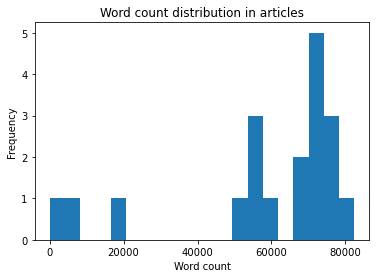

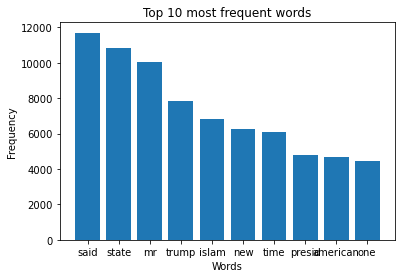

In [7]:

# Explore data: word count distribution
word_counts = [len(tokens) for tokens in tokenized_corpus]
plt.hist(word_counts, bins=20)
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.title('Word count distribution in articles')
plt.show()

# Explore data: top N most frequent words
N = 10
flat_tokens = [token for article_tokens in tokenized_corpus for token in article_tokens]
freq_dist = nltk.FreqDist(flat_tokens)
most_common = freq_dist.most_common(N)

plt.bar([word for word, _ in most_common], [count for _, count in most_common])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {N} most frequent words')
plt.show()

In [8]:
!pip install gensim


In [9]:
!pip install --user pyLDAvis


  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.24.3 which is incompatible.


In [10]:
import sys
import site

user_site_packages = site.getusersitepackages()
if user_site_packages not in sys.path:
    sys.path.append(user_site_packages)


In [12]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models
import seaborn as sns
import pyLDAvis # Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline
# Prepare the data for the LDA model
dictionary = corpora.Dictionary(tokenized_corpus)
doc_term_matrix = [dictionary.doc2bow(tokens) for tokens in tokenized_corpus]

# Train the LDA model
num_topics = 5
lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=20, random_state=42)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

    The prominence of Trump and American politics in the corpus suggests that the articles were heavily focused on the United States and its government during this time period. You could investigate the specific events or policies that were being covered during this time period.
    The topic of international relations and conflict, specifically related to Syria and Islam, suggests that there were likely many articles covering the ongoing conflict in Syria and the role of Islam in international relations. You could investigate the different perspectives presented in these articles and how they may have contributed to public perception of these issues.
    The appearance of the New York Times and the Wall Street Journal as a topic suggests that these two publications were particularly prominent in the corpus. You could investigate why these publications were chosen and whether there were any notable differences in the coverage between the two.
    The appearance of "state" and "would" as topics suggests that there may have been some discussion of hypothetical scenarios or potential government actions. You could investigate what specific scenarios or actions were being discussed and how they were being framed in the articles.

In [ ]:
num_topics_list = [3, 5, 7, 10]
passes_list = [5, 10, 20]
output_folder = 'lda_output'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for num_topics in num_topics_list:
    for passes in passes_list:
        lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=42)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_corpus, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()

        output_file = f"lda_{num_topics}_topics_{passes}_passes.txt"
        with open(os.path.join(output_folder, output_file), 'w') as f:
            for idx, topic in lda_model.print_topics(-1):
                f.write(f"Topic {idx+1}: {topic}\n")
            f.write(f"Coherence Score: {coherence_lda}\n")


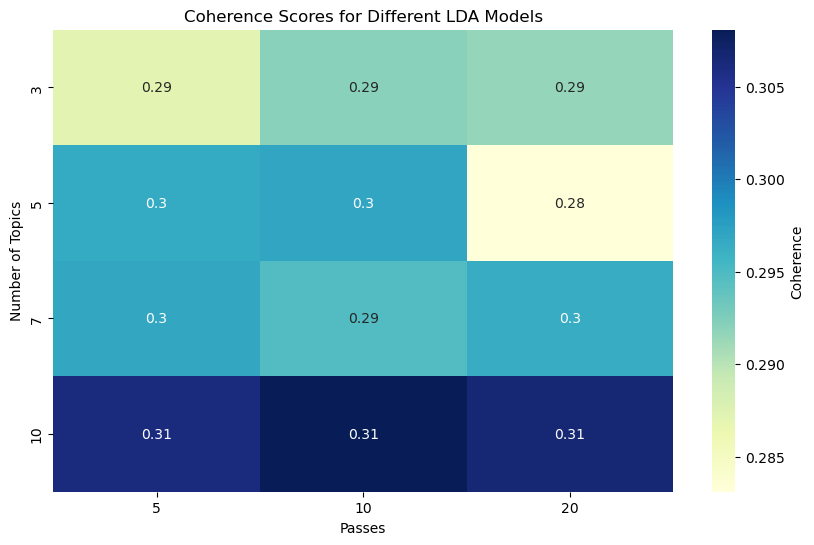

In [ ]:
coherence_matrix = []

for num_topics in num_topics_list:
    coherence_row = []
    for passes in passes_list:
        lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=42)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_corpus, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_row.append(coherence_lda)
    coherence_matrix.append(coherence_row)

coherence_df = pd.DataFrame(coherence_matrix, columns=passes_list, index=num_topics_list)

plt.figure(figsize=(10, 6))
sns.heatmap(coherence_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Coherence'})
plt.xlabel('Passes')
plt.ylabel('Number of Topics')
plt.title('Coherence Scores for Different LDA Models')
plt.show()
